# Constrained Optimization Using Pyomo

Now consider nonlinear optimization problems $\min_x F(x)$ with inequality constraints of the form $f(x) \leq 0$

First define a simple objective and a NL constraint equation.
Then take the appropriate derivatives


In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

import pyomo.environ as pyo
from pyomo.environ import *
#from pyomo.dae import *
from pyomo.opt import SolverFactory

Running Python: 3.9.9


In [2]:
global a, b
test_pt1 = np.array([-3,4])
test_pt2 = np.array([3,-4])

#define symbolic vars, function
sx,sy,sb,sa = sympy.symbols('x y b a')
fun = (sx**2 + 2*sx*sy + 2*sy**2)/2
constr = sy - ((sx-sb)**3-(sx-sb)**2+(sx-sb) - sa)

#take the gradient symbolically
gradfun=[sympy.diff(fun,var) for var in (sx,sy)]
gradconstr=[sympy.diff(constr,var) for var in (sx,sy)]

#turn into a bivariate lambda for numpy
numfun=sympy.lambdify([sx,sy],fun)
numconstr=sympy.lambdify([sx,sy,sb,sa],constr)
numgradfun=sympy.lambdify([sx,sy,sb,sa],gradfun)
numgradconstr=sympy.lambdify([sx,sy,sb,sa],gradconstr)

In [3]:
#Pick some values for the constraint function - changeable later
b = 1
a = 1.75

In [4]:
model = ConcreteModel()
# for access to dual solution for constraints
model.dual = Suffix(direction=Suffix.IMPORT)

# declare decision variables
model.x = Var(domain=Reals)
model.y = Var(domain=Reals)

# declare objective
model.obj = Objective(expr = numfun(model.x, model.y), sense = minimize)

# declare constraints
model.constraint = Constraint(expr = numconstr(model.x, model.y, b, a) <= 0)

# solve
SolverFactory('ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 2
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.22597098350524902
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [5]:
def plot_result(fig_num = 2, res = np.array([1,1,0])):
    fig = plt.figure(fig_num, figsize=(8 , 8))
    ax = fig.add_subplot(111)
    CS = ax.contour(X, Y, r, CL)
    ax.clabel(CS, inline=1, fontsize=14)
    ax.set_title('Objective min with nonlinear constraint')
    ax.set_ylim([-Range,Range])
    ax.set_xlim([-Range,Range])
    ax.set_aspect('equal')

    ax.plot(res[0], res[1], 'bo')
    ax.text(test_pt1[0], test_pt1[1], 'Constraint ftn = '+str(round(numconstr(test_pt1[0],test_pt1[1],b,a),2)),backgroundcolor='0.75',alpha=.9)
    ax.text(test_pt2[0], test_pt2[1], 'Constraint ftn = '+str(round(numconstr(test_pt2[0],test_pt2[1],b,a),2)),backgroundcolor='0.75',alpha=.9)
    ax.text(-3, -3, 'Lagrange Mult = '+str(round(res[2],3)),backgroundcolor='0.75',alpha=1)

    # find the y values of the constraint ftn
    Yb1 = -numconstr(x,0*x,b,a)
    ax.plot(x,Yb1,'r')

    # plot arrows
    jdel=0.5 # parameter for plotting arrows
    if (res[2] > 1e-6): # active contraint
        qq,ww = numgradconstr(res[0],res[1],b,a)
        fqq,fww = numgradfun(res[0],res[1],b,a)
        ax.arrow(res[0],res[1], jdel*fqq, jdel*fww, head_width=0.05,head_length=0.1,lw=3,ls='-')
        ax.arrow(res[0],res[1], jdel*qq, jdel*ww, head_width=0.05,head_length=0.1,lw=3,ls='-',color='g')
    else : # inactive contraint - don't show the arrows
        print('Constraints Inactive')
        # tempxx = -1
        # tempyy= -cons_f(np.array([tempxx,0*tempxx]))
        # qq,ww = numgradconstr(tempxx,tempyy,b)
        # ax.arrow(tempxx,tempyy, jdel*qq, jdel*ww, head_width=0.05,head_length=0.1,lw=3,ls='--',color='g')

In [6]:
print(f'Constrained solution [{model.x():.2f},{model.y():.2f}]')
# display all duals
#print ("Duals")
for c in model.component_objects(pyo.Constraint, active=True):
    #print ("   Constraint",c)
    for index in c:
        #print (index,str(round(model.dual[c[index]],4)))
        lam =  - model.dual[c[index]]
print(f'Lambda = {lam:.4f}')

res = np.array([model.x(),model.y(),lam])

Constrained solution [1.75,-1.14]
Lambda = 0.5165


# Nominal solution

Consider the solution with xshift$=3$. Note that the constraint is written as a $f((x-xshift)) \leq 0$.

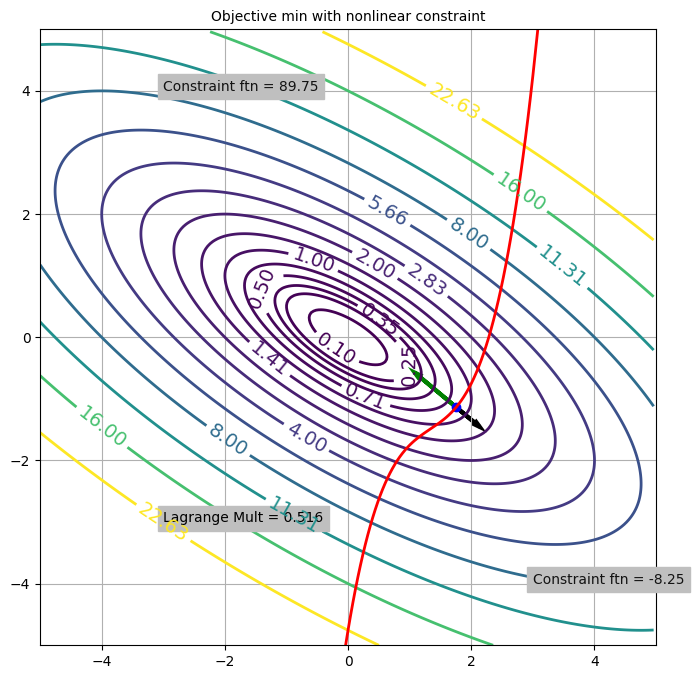

In [7]:
N_samples = 25
Range = 5
x = np.arange(-Range, Range, 1/N_samples)
y = np.arange(-Range, Range, 1/N_samples)
X, Y = np.meshgrid(x, y)

# Objective ftn
r = numfun(X,Y) # contour plot data

# contour colors
CL = 2**np.arange(-2, 5, .5)
CL = np.insert(CL,0,0.1)

# test pts to show the constraint pos/neg regions
test_pt1 = np.array([-3,4])
test_pt2 = np.array([3,-4])
#
plot_result(2,res)
plt.savefig("./figs/Pyomo_constrained.png")
plt.show()

Here:

- Red line is the constraint (positive above left, negative below right). The negative region is the feasible domain for the solution.

- The green arrow points in the direction of the constraint gradient (ie towards the positive/infeasible region)

- The black arrow points in the direction of the function increasing (i.e., away from the min) 

**Note:** at the optimal solution we would expect that 
$$
\frac{\partial F}{\partial \mathbf{x}} = 
- \boldsymbol{\lambda}^T \frac{\partial f}{\partial \mathbf{x}}
$$
So for positive $\lambda$ (i.e., an **active constraint**), would expect these arrows to be pointing in opposite directions. 

If the constraint is **inactive**, then $\lambda =0$ and the conditon is still satisfied, but trivially so.

In [8]:
np.set_printoptions(precision=3,suppress=True)
print(f'At solution [{res[0]:.2f},{res[1]:.2f}]')
LHS = numgradfun(res[0],res[1],b,a)
print(f'Function Gradient : [{LHS[0]:.2f},{LHS[1]:.2f}]') 
RHS = numgradconstr(res[0],res[1],b,a)
print(f'-Lambda*(Constraint Gradient) : [{-lam*RHS[0]:.2f},{-lam*RHS[1]:.2f}]') 
print('If correct, those 2 values should be the same.')

At solution [1.75,-1.14]
Function Gradient : [0.62,-0.52]
-Lambda*(Constraint Gradient) : [0.62,-0.52]
If correct, those 2 values should be the same.


# Experiment

In [9]:
def func(x_shift = 2, y_shift = 0):
    global a, b 
    b = x_shift
    a = y_shift
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)
    model.x = Var(domain=Reals)
    model.y = Var(domain=Reals)
    model.obj = Objective(expr = numfun(model.x, model.y), sense = minimize)
    model.constraint = Constraint(expr = numconstr(model.x, model.y, x_shift, y_shift) <= 0)
    SolverFactory('ipopt').solve(model)
    
    print(f'\nConstrained solution [{model.x():.2f},{model.y():.2f}]')
    for c in model.component_objects(pyo.Constraint, active=True):
        #print ("   Constraint",c)
        for index in c:
            lam =  - model.dual[c[index]]
    print(f'Lambda = {lam:.4f}')
    res = np.array([model.x(),model.y(),lam])
    plot_result(3,res)
    txt=f"Figure 2: Unconstrained min at [0, 0]. \n Constrained solution: [{model.x():.2f},{model.y():.2f}]\n Change Xshift and Yshift to move the constraint ftn"
    plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=16)
    plt.show()

y = interactive(func,{'manual': False},x_shift=(-3.5,4,1),y_shift=(-5,5,1))
y

interactive(children=(FloatSlider(value=2.0, description='x_shift', max=4.0, min=-3.5, step=1.0), IntSlider(va…